<a href="https://colab.research.google.com/github/ssimontacchi/1906_Traffic_Patterns_Market_St_SF/blob/master/People_count_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Cython

# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [0]:
import os

In [4]:
!git clone https://github.com/waleedka/coco.git /content/coco

fatal: destination path '/content/coco' already exists and is not an empty directory.


In [0]:
os.chdir( "/content/coco/PythonAPI")

In [6]:
!make install

# install pycocotools to the Python site-packages
python setup.py build_ext install
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
creating build/common
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c pycocotools/_mask.c -o build/temp.linux-x86_64-3.6/pycocotools/_mask.o -Wno-cpp -Wno-unused-function -std=c99
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=

In [0]:
os.chdir( "/content")

In [8]:
!pip3 install imgaug

In [9]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [0]:
import sys

os.chdir("/content/Mask_RCNN/samples")

In [0]:
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

In [13]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

Using TensorFlow backend.


In [0]:
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

In [0]:
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [16]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [17]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


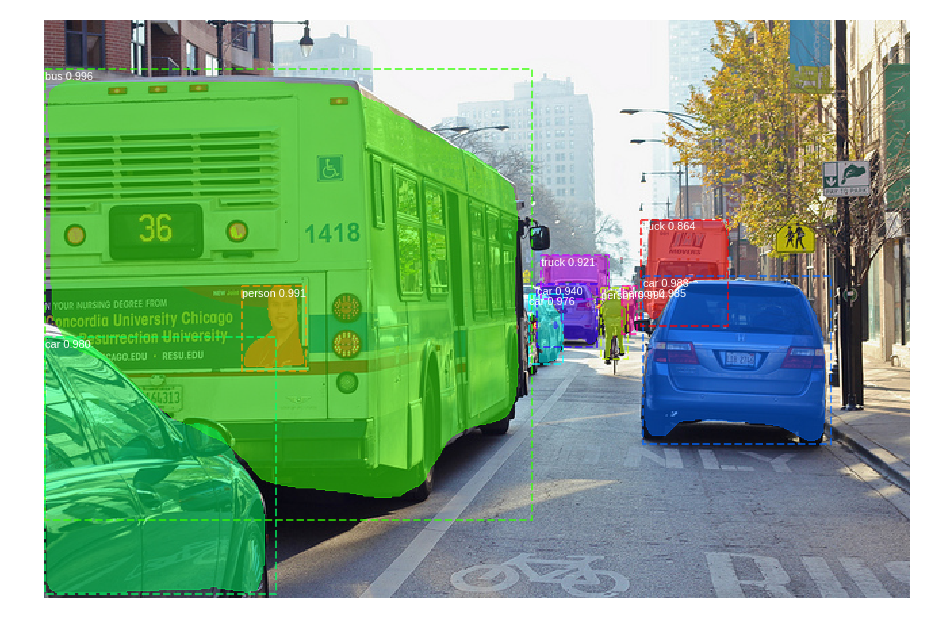

In [19]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [21]:
image = skimage.io.imread("https://upload.wikimedia.org/wikipedia/commons/9/97/Critical_Mass%2C_San_Francisco%2C_April_29%2C_2005.jpg")
# it works at 480, 640
image = skimage.transform.resize( image, (360, 540, 3) )
image = (image*255).astype(np.uint8)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
# Run detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (360, 540, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [0]:
#results

In [24]:
!ls

balloon  coco  demo.ipynb  nucleus  __pycache__  shapes  visualize2.py


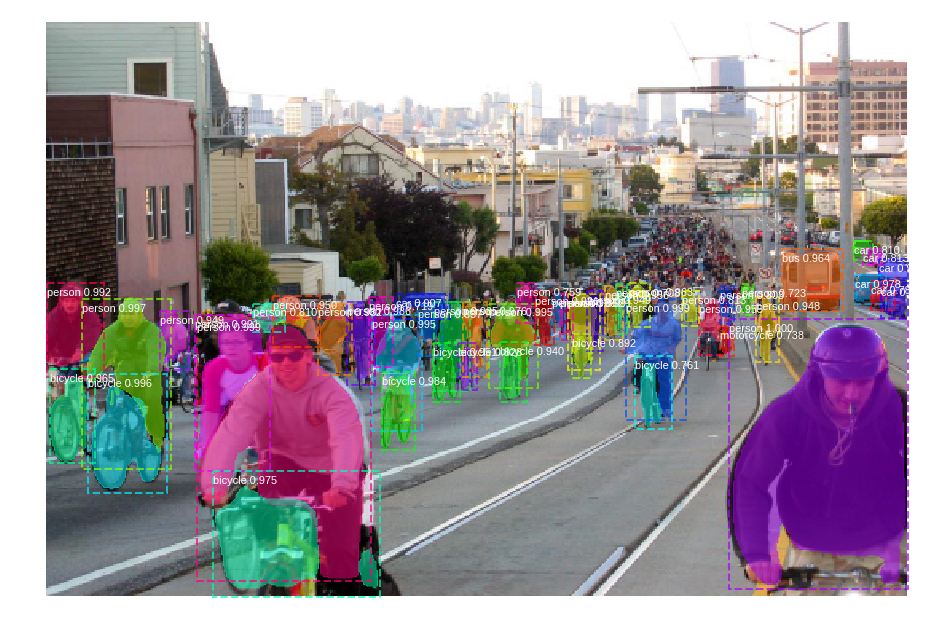

49 49
[186 428 355 540] 1


In [25]:
# Visualize results
#import visualize2

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
print(len(r['rois']), len(r['class_ids']))
print(r['rois'][0], r['class_ids'][0])

In [26]:
person_count = 0
for obj in r['class_ids']:
  if obj == 1:
    person_count += 1

print(person_count)

31


In [27]:
# for if I decide to track specific objects
'''
img1 = DetectedObjects(r)
print(len(img1.rois), len(img1.class_ids), len(img1.scores))
'''

'\nimg1 = DetectedObjects(r)\nprint(len(img1.rois), len(img1.class_ids), len(img1.scores))\n'

In [28]:
!pip3 install imageio

In [29]:
!imageio_download_bin ffmpeg

Ascertaining binaries for: ffmpeg.


In [0]:
import imageio

In [0]:
os.chdir("../mrcnn")

In [32]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name="visualize2.py", length=len(uploaded[fn])))

Saving visualize2.py to visualize2 (1).py
User uploaded file "visualize2.py" with length 19304 bytes


In [33]:
!ls

 1906_Traffic_Patterns_Market_St_SF   __pycache__
 config.py			      tracks_w_mask_test.mp4
 graph.jpg			      utils.py
 __init__.py			     'visualize2 (1).py'
 MarketSt.png			      visualize2.py
 model.py			      visualize.py
 parallel_model.py


In [0]:
import numpy as np
import cv2


class Line:
    """
    A Line is defined from two points (x1, y1) and (x2, y2) as follows:
    y - y1 = (y2 - y1) / (x2 - x1) * (x - x1)
    Each line has its own slope and intercept (bias).
    """
    def __init__(self, x1, y1, x2, y2):

        self.x1 = np.float32(x1)
        self.y1 = np.float32(y1)
        self.x2 = np.float32(x2)
        self.y2 = np.float32(y2)
        
        self.slope = self.compute_slope()
        self.b = self.compute_b()

    def compute_slope(self):
        if (int((self.x2 - self.x1))==0):
            return 100000
        return (self.y2 - self.y1) / (self.x2 - self.x1)

    def compute_b(self):
        return self.y1 - self.slope * self.x1

    def get_coords(self):
        return np.array([self.x1, self.y1, self.x2, self.y2])
    
    def return_x(self, y):
        '''From y-value, return x-value on the line.'''
        return (y-self.b)/self.slope

    def set_coords(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def draw(self, img, color=[255, 0, 0], thickness=10):
        cv2.line(img, (self.x1, self.y1), (self.x2, self.y2), color, thickness)


In [0]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def find_middle_line(lines):
    try:
        # if length is odd
        if (len(lines) % 2):
            mid_slope = np.median([l.slope for l in lines])
            for line in lines:
                if line.slope == mid_slope:
                    return line
        # and if length is even
        else:
            sorted_ms = np.sort([l.slope for l in lines])
            lower_mid_m = sorted_ms[int((len(sorted_ms)/2) - 1)]
            upper_mid_m = sorted_ms[int(len(sorted_ms)/2)]
            # return line closest to median slope
            if abs(lower_mid_m - np.median([l.slope for l in lines])) <  abs(upper_mid_m - np.median([l.slope for l in lines])):
                for line in lines:
                    if line.slope == lower_mid_m:
                        return line
            else:
                for line in lines:
                    if line.slope == upper_mid_m:
                        return line
    except:
        pass
    
# extend lines from median line
def extend_line(line, min_y, max_y):
    x_for_max_y = int((max_y-line.b)/line.slope)
    x_for_min_y = int((min_y-line.b)/line.slope) 

    return Line(x_for_min_y, min_y, x_for_max_y, max_y)


def find_intersection(line1, line2):
    '''
    Finds point of intersection between two lines.
    x = (b2 - b1)/(m1 - m2)
    '''
    x = (line2.b - line1.b)/(line1.slope - line2.slope)
    y = line1.slope*x + line1.b
    return (x, y)

In [0]:
def image_processing_pipeline(image):
     
    gray = grayscale(image)
    
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    try:
        # Define a kernel size and apply Gaussian smoothing
        kernel_size = 7
        blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

        # Define our parameters for Canny and apply
        low_threshold = 70
        high_threshold = 150
        edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

        # Next create a masked edges image using cv2.fillPoly()
        mask = np.zeros_like(edges)   
        ignore_mask_color = 255

        # This time we are defining a four sided polygon to mask
        imshape = image.shape
        vertices = np.array([[(150,imshape[0]), (245, 40), (360, imshape[0]),(350, imshape[0]), 
                      (245, imshape[0]-265), (160,imshape[0])]], dtype=np.int32)
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_edges = cv2.bitwise_and(edges, mask)

        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 2 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 5     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 30 # minimum number of pixels making up a line
        max_line_gap = 200    # maximum gap in pixels between connectable line segments

        # Run Hough on edge detected image
        # Output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)

        # put lines in a list
        detected_lines = [Line(l[0][0], l[0][1], l[0][2], l[0][3]) for l in lines]

        if len(detected_lines) != 0:
            candidate_lines = []
            for line in detected_lines:
                    # consider only lines with certain slopes
                    # inspired by https://github.com/ndrplz/self-driving-car/blob/master/project_1_lane_finding_basic/lane_detection.py
                    if 2 <= np.abs(line.slope) <= 3:
                        candidate_lines.append(line)

            # Identify both tracks
            pos_lines = [l for l in candidate_lines if l.slope > 0]
            neg_lines = [l for l in candidate_lines if l.slope < 0]

            # Pick "best" line
            mid_pos = find_middle_line(pos_lines)
            mid_neg = find_middle_line(neg_lines)

            # Can we extend the lines?
            try:    # need to identify why this breaks
                full_pos_line = extend_line(mid_pos, 0, imshape[0])
                full_neg_line = extend_line(mid_neg, 0, imshape[0])
            except:
                full_pos_line = mid_pos
                full_neg_line = mid_neg
            
            return full_pos_line, full_neg_line, line_image          
    except:
        return None, None, line_image

In [0]:
from collections import deque


class CableCarTrack:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Store recent linear coefficients for averaging across frames
        self.fitm = deque(maxlen=40)
        self.fitb = deque(maxlen=40)
        self.mprev = 0
        self.bprev = 0
        
        # Count the number of frames
        self.count = 0
        
    def avg_track_line(self, detected_track):
        '''
        This function is applied when the tracks have been detected in the previous frame.
        Averages the findings with previous results for smoother transitions. 
        '''
        self.count += 1
        if detected_track != None:
            self.fitm.appendleft(detected_track.slope)
            self.fitb.appendleft(detected_track.b)

            # use m's and b's from fitm and fit b for best fit
            weights = [.025 for i in range(40)]
            weighted_avg_fitm, weighted_avg_fitb = 0, 0
            # if in the first 10 frames, temporarily fill the deque with the average
            if len(self.fitb) < 40:
                # I think the better way to do this is to weight the points closest to each other
                m_mean = np.mean(self.fitm)
                b_mean = np.mean(self.fitb)
            temp_fitm = self.fitm.copy()
            temp_fitb = self.fitb.copy()
            for i in range(40-len(self.fitm)):
                temp_fitm.append(m_mean)
                temp_fitb.append(b_mean)
            for i in range(40):
                weighted_avg_fitm += weights[i]* temp_fitm[i]
                weighted_avg_fitb += weights[i]* temp_fitb[i]
            
            self.mprev = weighted_avg_fitm
            self.bprev = weighted_avg_fitb
            
        else:
            # if no track found, use previously found track
            weighted_avg_fitm = self.mprev
            weighted_avg_fitb = self.bprev
        
        
        return weighted_avg_fitm, weighted_avg_fitb

In [0]:
class NumPeople:
    def __init__(self):
        self.num_people = []
        
    def people_in_frame(self, r):
        person_count = 0
        for obj in r['class_ids']:
          if obj == 1:
            person_count += 1
        self.num_people.append(person_count)
        
    def get_people_list(self):
        return self.num_people
            

In [39]:
# The beginnings of code to track if an object detected is the same as the previous object

'''
class Thing:
    def __init__(self)
        # Is this the first 
        self.count = 0
    
        self.past_locs = deque(maxlen=10)

    def trajectory(current_location)
        # Where is it
        self.x = current_location[1]
        self.y = current_location[0]
        
        if 
          self.past
          
    def get_last_loc(self):
        return self.past_locs[0]
        
        
        
        

class DetectedObjects:
    def __init__(self, detection_results):
        self.rois = detection_results['rois']
        self.location = (self.rois[2], (int((self.rois[3]-self.rois[1])/2) # (y, x)
        
        
        self.class_ids = detection_results['class_ids'] 
        self.scores = detection_results['scores']
        
        
        for i 
        
        # Remember x and y values of object in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Store recent linear coefficients for averaging across frames
        self.fitm = deque(maxlen=40)
        self.fitb = deque(maxlen=40)
        self.mprev = 0
        self.bprev = 0
        
        # Count the number of frames
        self.count = 0
        
        
    
    
    def avg_track_line(self, detected_track):
       
        #This function is applied when the tracks have been detected in the previous frame.
        #Averages the findings with previous results for smoother transitions. 
       
        self.count += 1
        if detected_track != None:
            self.fitm.appendleft(detected_track.slope)
            self.fitb.appendleft(detected_track.b)

            # use m's and b's from fitm and fit b for best fit
            weights = [.025 for i in range(40)]
            weighted_avg_fitm, weighted_avg_fitb = 0, 0
            # if in the first 10 frames, temporarily fill the deque with the average
            if len(self.fitb) < 40:
                # I think the better way to do this is to weight the points closest to each other
                m_mean = np.mean(self.fitm)
                b_mean = np.mean(self.fitb)
            temp_fitm = self.fitm.copy()
            temp_fitb = self.fitb.copy()
            for i in range(40-len(self.fitm)):
                temp_fitm.append(m_mean)
                temp_fitb.append(b_mean)
            for i in range(40):
                weighted_avg_fitm += weights[i]* temp_fitm[i]
                weighted_avg_fitb += weights[i]* temp_fitb[i]
            
            self.mprev = weighted_avg_fitm
            self.bprev = weighted_avg_fitb
            
        else:
            # if no track found, use previously found track
            weighted_avg_fitm = self.mprev
            weighted_avg_fitb = self.bprev
        
        
        return weighted_avg_fitm, weighted_avg_fitb
        
'''

"\nclass Thing:\n    def __init__(self)\n        # Is this the first \n        self.count = 0\n    \n        self.past_locs = deque(maxlen=10)\n\n    def trajectory(current_location)\n        # Where is it\n        self.x = current_location[1]\n        self.y = current_location[0]\n        \n        if \n          self.past\n          \n    def get_last_loc(self):\n        return self.past_locs[0]\n        \n        \n        \n        \n\nclass DetectedObjects:\n    def __init__(self, detection_results):\n        self.rois = detection_results['rois']\n        self.location = (self.rois[2], (int((self.rois[3]-self.rois[1])/2) # (y, x)\n        \n        \n        self.class_ids = detection_results['class_ids'] \n        self.scores = detection_results['scores']\n        \n        \n        for i \n        \n        # Remember x and y values of object in previous frame\n        self.X = None\n        self.Y = None\n        \n        # Store recent x intercepts for averaging across frame

In [0]:
# def affine_transformation()

In [41]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name="MarketSt.png", length=len(uploaded[fn])))

Saving MarketSt.png to MarketSt (1).png
User uploaded file "MarketSt.png" with length 518388 bytes


In [0]:
%load_ext autoreload
%autoreload 2

import visualize2
import pylab

def process_vid(image):
    
    # process image to find line candidates
    pos_line, neg_line, line_image = image_processing_pipeline(image)
    
    if ((pos_line != None) and (neg_line != None)):
      # Input pos_line and neg_line into CableCarTrack object to find avg line
      leftm, leftb = Left.avg_track_line(neg_line)
      rightm, rightb = Right.avg_track_line(pos_line)

      # Create Line objects to be drawn from m and b
      left_x1 = (0 - leftb)/leftm                    # x1, 0
      left_x2 = (image.shape[1] - leftb)/leftm       # x2, top of image
      right_x1 = (0 - rightb)/rightm                 # x1, 0
      right_x2 = (image.shape[1] - rightb)/rightm    # x2, top of image

      best_left = Line(left_x1, 0, left_x2, image.shape[1])
      best_right = Line(right_x1, 0, right_x2, image.shape[1])

      # Find focal point / intersection of lines
      xi, yi = find_intersection(best_right, best_left)
   
   ### Maybe check frame number and if less than 10, set xi, yi to 248, 91
      

      # shrink full lines to final lines by reducing them to just above the point of intersection
      final_pos_line = Line(best_right.get_coords()[2], best_right.get_coords()[3], 
                            best_right.return_x(yi + 2), yi + 2)
      final_neg_line = Line(best_left.get_coords()[2], best_left.get_coords()[3], 
                            best_left.return_x(yi + 2), yi + 2)
      
      ### Note: Had to edit visualize2.display_instances to return the image

      # for l in [final_pos_line, final_neg_line]:
          #l.draw(line_image) # TURNED OFF FOR PEOPLE DETECTION
   
      # rescale image to pass into the model so same size as line_image
      image = skimage.transform.resize(image, (360, 540, 3))
      image = (image*255).astype(np.uint8)
      
    else:
      # if we can't find lines, use the original image
      image = skimage.transform.resize(image, (360, 540, 3))
      image = (image*255).astype(np.uint8)
      
      line_image = image
    
    ### DRAWING
    results = model.detect([image], verbose = 0)
    # visualization
    r = results[0]

    people_count.people_in_frame(r)
    test_people_list = people_count.get_people_list()

    # 1. Makes image of number of people tracked over Market Street
    fig, ax = plt.subplots(figsize=(20,3))
    dist_per_frame_feet = 0.4046752251389155
    x = np.linspace(0, (len(test_people_list)-1)*dist_per_frame_feet, len(test_people_list))
    img = plt.imread("MarketSt.png")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    dist_total_feet = 8448
    ax.imshow(img, aspect='auto', extent=[0, dist_total_feet, 2, 30])
    ax.axvline(x=(len(test_people_list)-1)*dist_per_frame_feet, color="white")
    ax.plot(x, test_people_list, color='white')
    pylab.savefig('graph.jpg', bbox_inches='tight')
    output = plt.imread("graph.jpg")
    # 2. Convert it to an array
    output_array = np.asarray(output)
    # 3. Resize it using cv2
    small_graph = cv2.resize(output_array, (520, 75))
    #  plt.imshow(small_graph)


    # Below prints the first bounding box with coordinates (y1, x1, y2, x2). First pt is top-left, 2nd is bottom-right
    # print(r['rois'][0])

    ### Loop through r['rois'] and convert all points to distances with affine transformation
    # 1. Get box parameters and identify center-bottom of box (y2, (x2-x1)/2)
    # 2. 

    result_image = visualize2.display_instances(
        image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

    line_image = cv2.addWeighted(line_image, .8, result_image, .8, 0)

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, .8, line_image, .8, 0)
    
    # 4. Rewrite analysis on top of the image
    lines_edges.setflags(write=1)
    x_offset = int((lines_edges.shape[1] - small_graph.shape[1])/2)
    lines_edges[275:275+small_graph.shape[0], x_offset:x_offset + small_graph.shape[1]] = small_graph
    # ax.imshow(lines_edges, cmap="gray");

    return lines_edges

In [43]:
!ls

 1906_Traffic_Patterns_Market_St_SF   parallel_model.py
 config.py			      __pycache__
 graph.jpg			      tracks_w_mask_test.mp4
 __init__.py			      utils.py
'MarketSt (1).png'		     'visualize2 (1).py'
 MarketSt.png			      visualize2.py
 model.py			      visualize.py


In [44]:
!pip install moviepy

In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import io
import base64

In [46]:
!git clone https://github.com/ssimontacchi/1906_Traffic_Patterns_Market_St_SF.git


fatal: destination path '1906_Traffic_Patterns_Market_St_SF' already exists and is not an empty directory.


In [0]:
%%capture
Left = CableCarTrack()
Right = CableCarTrack()
people_count = NumPeople()

tracks_output = 'tracks_w_mask_test.mp4'
clip2  = VideoFileClip('1906_Traffic_Patterns_Market_St_SF/short_test.mp4')
fp_clip = clip2.fl_image(process_vid)
%time fp_clip.write_videofile(tracks_output, audio=False)

In [48]:
video = io.open('tracks_w_mask_test.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

In [49]:
!ls

 1906_Traffic_Patterns_Market_St_SF   parallel_model.py
 config.py			      __pycache__
 graph.jpg			      tracks_w_mask_test.mp4
 __init__.py			      utils.py
'MarketSt (1).png'		     'visualize2 (1).py'
 MarketSt.png			      visualize2.py
 model.py			      visualize.py


In [50]:
"""
%%capture
Left = CableCarTrack()
Right = CableCarTrack()
people_count = NumPeople()

tracks_output = 'tracks_w_mask_test.mp4'
clip2  = VideoFileClip('1906_Traffic_Patterns_Market_St_SF/MarketStreet1906WithStreetSounds.mp4')
fp_clip = clip2.fl_image(process_vid)
%time fp_clip.write_videofile(tracks_output, audio=False)
"""

"\n%%capture\nLeft = CableCarTrack()\nRight = CableCarTrack()\npeople_count = NumPeople()\n\ntracks_output = 'tracks_w_mask_test.mp4'\nclip2  = VideoFileClip('1906_Traffic_Patterns_Market_St_SF/MarketStreet1906WithStreetSounds.mp4')\nfp_clip = clip2.fl_image(process_vid)\n%time fp_clip.write_videofile(tracks_output, audio=False)\n"

In [0]:
# Function to download generated output

def download_output(exportAs = "MP4"):
  from google.colab import files
  import shutil
  
  if exportAs is "MP4":
    files.download("tracks_w_mask_test.mp4")
  else:
    shutil.make_archive("1906_analysis", 'zip', IMAGE_DIR)
    files.download("1906_analysis.zip")

download_output()

In [52]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name="MarketSt.jpg", length=len(uploaded[fn])))

In [0]:
##### This pickles test_people_list.p

import pickle
from google.colab import files

### Following lines build pickle file
test_people_list = people_count.get_people_list()

filename = "test_people_list.p"
outfile = open(filename,'wb')
pickle.dump(people_count.get_people_list(), outfile)
outfile.close()

files.download('test_people_list.p')

In [54]:
import pickle

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name="test_people_list.p", length=len(uploaded[fn])))

test_people_list = pickle.load(open("test_people_list.p", "rb" ))

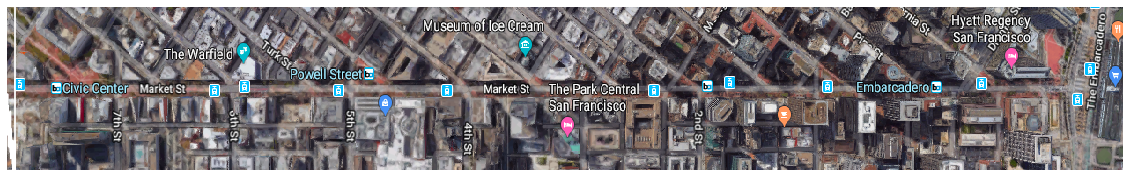

In [55]:
import pylab 

fig, ax = plt.subplots(figsize=(20,3))
dist_per_frame_feet = 0.4046752251389155
x = np.linspace(0, (len(test_people_list)-1)*dist_per_frame_feet, len(test_people_list))
img = plt.imread("MarketSt.png")
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
dist_total_feet = 8448
ax.imshow(img, aspect='auto', extent=[0, dist_total_feet, 2, 30])
ax.axvline(x=(len(test_people_list)-1)*dist_per_frame_feet, color="white")
ax.plot(x, test_people_list, color='white')
pylab.savefig('graph.jpg', bbox_inches='tight')

In [56]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name="frame19025.jpg", length=len(uploaded[fn])))

FileNotFoundError: ignored

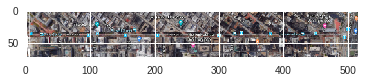

In [57]:
import cv2
import pylab

# plan is to: 
# 1. Convert matplotlib output to jpg
#pylab.savefig('graph.jpg', bbox_inches='tight')
# 2. Convert it to an array
output = plt.imread("graph.jpg")
output_array = np.asarray(output)
# 3. Resize it using cv2
small_graph = cv2.resize(output_array, (520, 75))
plt.imshow(small_graph)

# 4. Rewrite it on top of the image
img2 = plt.imread("frame19025.jpg")
img2_array = np.asarray(img2)

img2_array.setflags(write=1)
x_offset = int((img2_array.shape[1] - small_graph.shape[1])/2)
img2_array[275:275+small_graph.shape[0], x_offset:x_offset + small_graph.shape[1]] = small_graph

plt.grid(False)
plt.imshow(img2_array);

In [0]:
## Function to input a video and output multiple frames with their detection
import time
import cv2


def video_to_frames(input_vid, output_loc, max_fps = None):
  # check if folder already exist otherwise mkdir
  if not os.path.exists(output_loc):
    os.mkdir(output_loc)
    print("%s was created" % output_loc)
  # log the time
  time_start = time.time()
  # capture frame
  cap = cv2.VideoCapture(input_vid)
  count = 0
  print('\nRunning Mask R-CNN on %s' % input_vid)
  
  try:
    while True:
      status, image = cap.read()
######## insert processing
      # run detection
      results = model.detect([image], verbose = 0)
      # visualization
      r = results[0]
      result_image = visualize.display_instances(
          image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
      )
      
######## this is where I could insert more processing

      cv2.imwrite(output_loc + "/frame%04d.jpg" % count, result_image)
      count += 1
      # print every 50 frames
      if count % 50 == 0:
        time_mid = time.time()
        print("%d frames converted. Time elapsed: %d seconds." % (count, (time_mid - time_start)))
      # set upper limit
      if not max_fps == None:
        if count > max_fps:
          break

  except Exception as e:
    print("There was an error!")
    print(e)
 
  cap.release()
	# log the time again
  time_end = time.time()
  print("%d frames converted at %d frames per second\n" % (count, (count/(time_end - time_start))))
  print("Conversion time: %d seconds." % (time_end - time_start))
  
def single_frame_detection(path, title="", figsize=(16, 16), ax=None):  
  image = scipy.misc.imread(path)
  
  if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
  
  # Show area outside image boundaries.
  height, width = image.shape[:2]
  ax.set_ylim(height + 10, -10)
  ax.set_xlim(-10, width + 10)
  ax.axis('off')
  ax.set_title(title)
  
  # Run detection
  results = model.detect([image], verbose=0)
  # Visualize results
  r = results[0]
  result_image = display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

  plt.imshow(result_image)
  plt.show()

In [0]:
## Function to combine frames into a video

def frames_to_video(input_folder, outvid=None, fps=30, size=None,
               is_color=True, format='MP4V'):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    image_dir = sorted(os.listdir(input_folder))
    vid = None
    for i in image_dir:
      image = os.path.join(input_folder, i)
      if not os.path.exists(image):
        raise FileNotFoundError(image)
      img = imread(image)
      if vid is None:
        if size is None:
          size = img.shape[1], img.shape[0]
          vid = VideoWriter('out.mp4', fourcc, float(fps), size, is_color)
      if size[0] != img.shape[1] and size[1] != img.shape[0]:
        img = resize(img, size)
      vid.write(img)
    vid.release()

# Function to download generated output

def download_output(exportAs = "MP4"):
  from google.colab import files
  import shutil
  
  if exportAs is "MP4":
    files.download("out.mp4")
  else:
    shutil.make_archive("youtube-object-detection", 'zip', IMAGE_DIR)
    files.download("youtube-object-detection.zip")
    
def upload():
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [0]:
IMAGE_DIR = "output-dir" # dir to save images

# Run detection and output frames
video_to_frames(input_vid = filename, output_loc = IMAGE_DIR, max_fps=30*60)

In [0]:
# Combine frames into video

frames_to_video(IMAGE_DIR)

# Download result
download_output()

In [0]:
!ls

In [0]:
! open ./output-dir/frame0033.jpg

In [0]:
!pip install ffmpeg

In [0]:
import cv2
import argparse
import os

# Construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-ext", "--extension", required=False, default='png', help="extension name. default is 'png'.")
ap.add_argument("-o", "--output", required=False, default='output.mp4', help="output video file")
args = vars(ap.parse_args())

# Arguments
dir_path = IMAGE_DIR
ext = args['extension']
output = args['output']

images = []
for f in os.listdir(IMAGE_DIR):
    if f.endswith(ext):
        images.append(f)

# Determine the width and height from the first image
image_path = os.path.join(IMAGE_DIR, images[0])
frame = cv2.imread(image_path)
cv2.imshow('video',frame)
height, width, channels = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter(output, fourcc, 20.0, (width, height))

for image in images:

    image_path = os.path.join(IMAGE_DIR, image)
    frame = cv2.imread(image_path)

    out.write(frame) # Write out frame to video

    cv2.imshow('video',frame)
    if (cv2.waitKey(1) & 0xFF) == ord('q'): # Hit `q` to exit
        break

# Release everything if job is finished
out.release()
cv2.destroyAllWindows()

print("The output video is {}".format(output))

In [0]:
!ls